In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Task 1: Data Exploration

In [76]:
df = pd.read_csv("./electricity-consumption-processed.csv")


### First rows and useful statistics

Displaying the first rows of the dataset.

In [77]:
df.head(10)

,datetime,substation,feeder,consumption
0,2017-01-01T00:00:00,A,A1,64.671363
1,2017-01-01T01:00:00,A,A1,58.000000
2,2017-01-01T02:00:00,A,A1,58.000000
3,2017-01-01T03:00:00,A,A1,58.000000
4,2017-01-01T04:00:00,A,A1,52.000000
5,2017-01-01T05:00:00,A,A1,45.000000
6,2017-01-01T06:00:00,A,A1,42.000000
7,2017-01-01T07:00:00,A,A1,43.000000
8,2017-01-01T08:00:00,A,A1,45.000000
9,2017-01-01T09:00:00,A,A1,44.000000


Displaying the shape of the dataset on form (rows, column)

In [78]:
df.shape

(1928520, 4)

From this we can see that they have split the time-series in intervals of 1 hour, and a total of 24 points of data per day. Furthermore, the dataset also points to a substation. All the data from substation A is the following:

In [79]:
substation_df = df[df['substation'] == 'A']
substation_df.shape

(70128, 4)

With 70 128 rows of data for one subregion we have the following dates, weeks and years spanning in the dataset:

In [80]:
points_per_day = 24
dataset_in_days = substation_df.shape[0] / points_per_day

print(f"Days in dataset: {dataset_in_days}")

dataset_in_weeks = dataset_in_days / 7 # 7 days per week

print(f"Weeks in dataset: {dataset_in_weeks}")

dataset_in_years = dataset_in_weeks / 52 # 52 weeks in a year

print(f"Years in dataset: {dataset_in_years}")


Days in dataset: 2922.0
Weeks in dataset: 417.42857142857144
Years in dataset: 8.027472527472527


Creating statistics of the dataset

In [81]:
df.describe()

,consumption
count,1.884960e+06
mean,1.018534e+02
std,6.220330e+01
min,1.264627e+00
25%,5.300000e+01
50%,8.825000e+01
75%,1.410000e+02
max,4.120000e+02


**Identifyting missing values**

In [82]:
missing_values = df.isnull().sum()
print(missing_values)

datetime           0
substation         0
feeder             0
consumption    43560
dtype: int64


**Identifying unique values**

In [83]:
unique_consumption = df['consumption'].unique()
unique_consumption.size

113867

There are 113 864 unique values for the consumption columm.

**Outliers**

Have chosen to use Interquartile Range (IQR) as this is more suitable to handle skewed data. This is certainly the case here, as electricity consumption varies from day to day, as well as the season and weather conditions. If the data had been normally ditributed, calculating ouliers using z-score would be more useful.

In [84]:
q1 = df['consumption'].quantile(0.25)
q3 = df['consumption'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['consumption'] < lower_bound) | (df['consumption'] > upper_bound)]
print(outliers)

                    datetime substation feeder  consumption
71104    2017-02-10T16:00:00          B     B1        285.0
71392    2017-02-22T16:00:00          B     B1        288.0
71600    2017-03-03T08:00:00          B     B1        288.0
71601    2017-03-03T09:00:00          B     B1        281.0
71603    2017-03-03T11:00:00          B     B1        307.0
...                      ...        ...    ...          ...
1892579  2020-11-25T11:00:00          N     N3        276.0
1892582  2020-11-25T14:00:00          N     N3        306.0
1892583  2020-11-25T15:00:00          N     N3        288.0
1892966  2020-12-11T14:00:00          N     N3        277.0
1892967  2020-12-11T15:00:00          N     N3        277.0

[17444 rows x 4 columns]


Of the total of 1 928 520 total entries, there are 17 444 outliers.

In [85]:
round(outliers.size / df.size * 100, 4)

0.9045

This accounts for approximately 0.9045 %

# Task 2: Data Cleaning

Displaying where the missing values are located in the dataset.

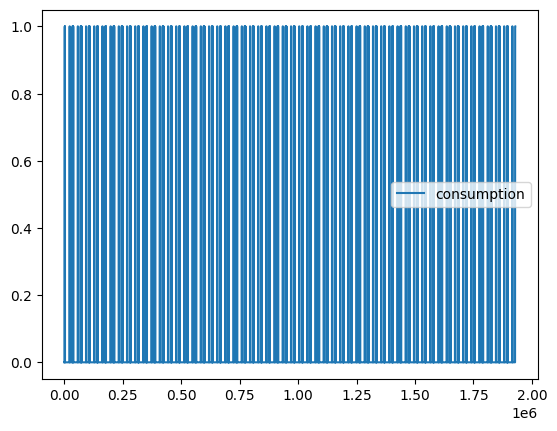

In [86]:
fig, ax = plt.subplots()

consumption_null = df['consumption'].isnull()
ax.plot(consumption_null)

ax.legend(['consumption'])


We chose to linear interpolate between the last known value and the next known. This is mainly because missing datapoints seems to be random. It seems logical to interpolate the data as it maps back to the real world, where seasonal changes vary, but dates within a short timeperiod should corralate more or less.

In [87]:
df['consumption'] = df['consumption'].interpolate(method='linear')
df['consumption']


0          64.671363
1          58.000000
2          58.000000
3          58.000000
4          52.000000
             ...    
1928515    35.000000
1928516    35.000000
1928517    35.000000
1928518    35.000000
1928519    35.000000
Name: consumption, Length: 1928520, dtype: float64

# Task 3: Handling outliers

Display IQR (Interquartile range), outliers shown by the red circles.

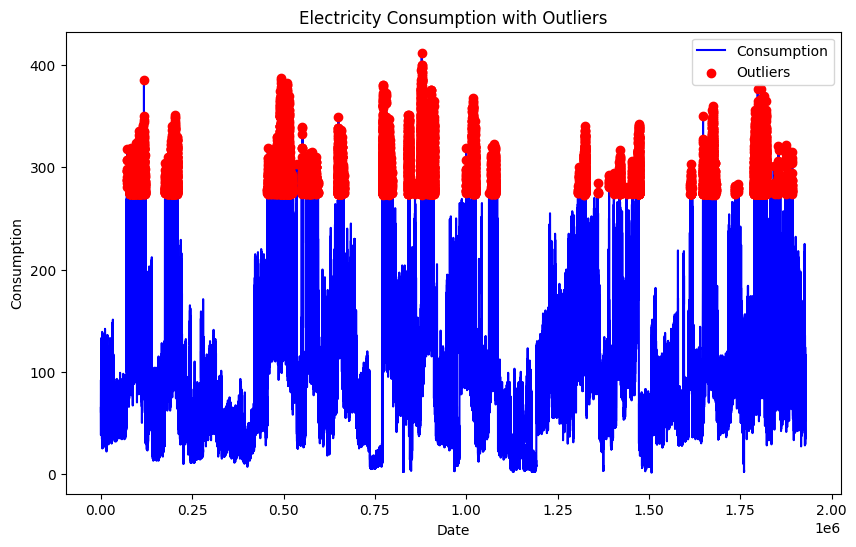

In [88]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['consumption'], label='Consumption', color='blue')

plt.scatter(outliers.index, outliers['consumption'], color='red', label='Outliers', zorder=5)

plt.title('Electricity Consumption with Outliers')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()

plt.show()

We chose to cap the data, due to the fact that the amount i rather large (a bit less than 70 000) and skewed. This will help reduce the impact of extreme values, but not remove them completely. Furthermore, our interest in this dataset is to make predictions and spot general trends. In this case outliers are not perticularly interesting, and we therefore find it natural to minimise their effect without completely removing them. To cap the dataset rather than transforming it also makes it easier to explain the data to a potential client.

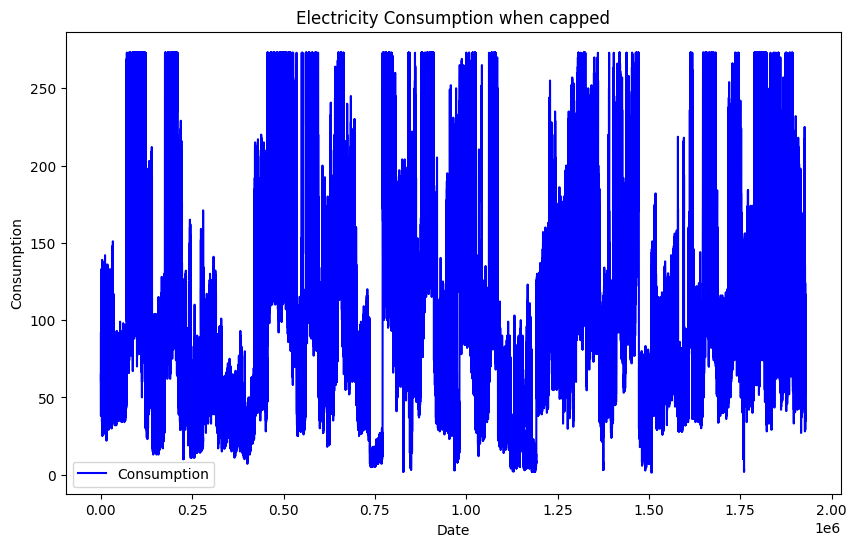

In [89]:
df['consumption'] = df['consumption'].clip(lower=lower_bound, upper=upper_bound)

plt.figure(figsize=(10, 6))

plt.plot(df.index, df['consumption'], label='Consumption', color='blue')

plt.title('Electricity Consumption when capped')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()

plt.show()

# Task 4: Data Transformation

From the information we have available about this dataset, the substations are not ordinal and only unique identifiers for the specific substations. We have therefore chosen to apply one-shot encoding to them. Additionally, since the feeders seem like identifiers from information available to us, we've chosen to also apply one-hot encoding to them. This ensures theres no risk of the model assuming false relationships that might have accured if we used label encoding.

In [90]:
categorical_columns = ['substation', 'feeder']

df_encoded = pd.get_dummies(df, columns=categorical_columns, dtype='int')

print(df_encoded.head())

              datetime  consumption  substation_A  substation_B  substation_C  \
0  2017-01-01T00:00:00    64.671363             1             0             0   
1  2017-01-01T01:00:00    58.000000             1             0             0   
2  2017-01-01T02:00:00    58.000000             1             0             0   
3  2017-01-01T03:00:00    58.000000             1             0             0   
4  2017-01-01T04:00:00    52.000000             1             0             0   

   substation_D  substation_E  substation_F  substation_G  substation_H  ...  \
0             0             0             0             0             0  ...   
1             0             0             0             0             0  ...   
2             0             0             0             0             0  ...   
3             0             0             0             0             0  ...   
4             0             0             0             0             0  ...   

   feeder_M2  feeder_M3  feeder_

Because the data is skewed, large, and the outliers are already getting capped, we've opted to use min-max feature scaling since its outlier sensitivity wasnt a concern anymore. Additionally we wanted to preserve the relationships between the different datapoints that min-max scaling allows us to do.

In [91]:
numerical_columns = ['consumption']

scaler = MinMaxScaler()

df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

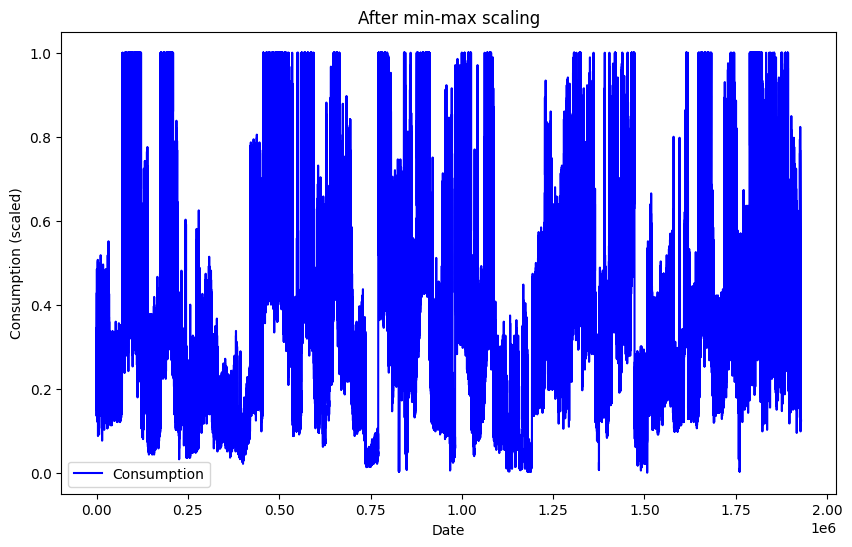

In [92]:
plt.figure(figsize=(10, 6))

plt.plot(df_encoded.index, df_encoded['consumption'], label='Consumption', color='blue')

plt.title('After min-max scaling')
plt.xlabel('Date')
plt.ylabel('Consumption (scaled)')
plt.legend()

plt.show()

Feature scaling is necessary to use because it ensures faster convergence and prevents feature dominance. With scaled features, algorithms also perform better and lead to more accurate models.

# Task 5: Data splitting

In [93]:
# Define features (X) and target (y)
X = df[['datetime', 'substation', 'feeder']]  # Feature columns
y = df['consumption']  # Target column

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (1542816, 3)
Testing set size: (385704, 3)


Splitting data into training and testing sets is important in training machine learning models. When we train a model, we want it to learn underlying patterns from the data that can be applied to new data, not just memorize the training data. This is where the concept of overfitting comes into play.

Overfitting occurs when a model becomes too complex, capturing not only the true patterns in the data but also noise or random fluctuations. This means the model performs very well on the training data but poorly on new data. Essentially, it memorizes the training data instead of generalizing well to other datasets. Overfitting leads to poor performance in real-world scenarios where the model is applied to new data.

By splitting the dataset into a training set and a testing set, we can reduce the risk of overfitting. The training set is used to train the model, learning from the data. The testing set, which the model has never seen before, acts as a test for real-world data. After training, the model is evaluated on the testing set, giving an estimate of how well it is likely to perform on new data.

This split makes us able to evaluate the model’s generalization ability. If a model performs well on both the training and testing sets, it’s likely capturing the true underlying patterns. If it performs well only on the training set but poorly on the testing set, overfitting is likely, and we may need to adjust the model by reducing its complexity, using regularization techniques, or collecting more data